# Lab 5 Group 9
## Michael Karaman, Alexys Lamkin, Yiyun Zhang

### 2. Installation and Examples

In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://mirrors.advancedhosters.com/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz

In [ ]:
!tar xf spark-3.0.3-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark pyspark graphframes

     |████████████████████████████████| 212.4 MB 64 kB/s 
     |████████████████████████████████| 198 kB 53.0 MB/s 
     |████████████████████████████████| 154 kB 51.4 MB/s 


In [ ]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
os.environ["HADOOP_HOME"] = os.environ["SPARK_HOME"]

os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

def init_spark(app_name="colab", execution_mode="local[*]"):
  spark = SparkSession.builder.master(execution_mode).appName(app_name).getOrCreate()
  sc = spark.sparkContext
  return spark, sc

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

_, sc = init_spark()
sqlContext = SQLContext(sc)

# Create a Vertex DataFrame with unique ID column "id"
v = sqlContext.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
], ["id", "name", "age"])
# Create an Edge DataFrame with "src" and "dst" columns
e = sqlContext.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
], ["src", "dst", "relationship"])
# Create a GraphFrame
from graphframes import *
g = GraphFrame(v, e)

# Query: Get in-degree of each vertex.
g.inDegrees.show()

# Query: Count the number of "follow" connections in the graph.
g.edges.filter("relationship = 'follow'").count()

# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.01, maxIter=20)
results.vertices.select("id", "pagerank").show()

+---+--------+
| id|inDegree|
+---+--------+
|  c|       1|
|  b|       2|
+---+--------+

+---+------------------+
| id|          pagerank|
+---+------------------+
|  b|1.0905890109440908|
|  a|              0.01|
|  c|1.8994109890559092|
+---+------------------+



In [ ]:
from graphframes.examples import Graphs
g = Graphs(sqlContext).friends()  # Get example graph

# Display the vertex and edge DataFrames
g.vertices.show()
# +--+-------+---+
# |id|   name|age|
# +--+-------+---+
# | a|  Alice| 34|
# | b|    Bob| 36|
# | c|Charlie| 30|
# | d|  David| 29|
# | e| Esther| 32|
# | f|  Fanny| 36|
# | g|  Gabby| 60|
# +--+-------+---+

g.edges.show()
# +---+---+------------+
# |src|dst|relationship|
# +---+---+------------+
# |  a|  b|      friend|
# |  b|  c|      follow|
# |  c|  b|      follow|
# |  f|  c|      follow|
# |  e|  f|      follow|
# |  e|  d|      friend|
# |  d|  a|      friend|
# |  a|  e|      friend|
# +---+---+------------+

# Get a DataFrame with columns "id" and "inDegree" (in-degree)
vertexInDegrees = g.inDegrees

# Find the youngest user's age in the graph.
# This queries the vertex DataFrame.
g.vertices.groupBy().min("age").show()

# Count the number of "follows" in the graph.
# This queries the edge DataFrame.
numFollows = g.edges.filter("relationship = 'follow'").count()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
+---+-------+---+

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
+---+---+------------+

+--------+
|min(age)|
+--------+
|      29|
+--------+



In [ ]:
from graphframes.examples import Graphs
g = Graphs(sqlContext).friends()  # Get example graph

# Search for pairs of vertices with edges in both directions between them.
motifs = g.find("(a)-[e]->(b); (b)-[e2]->(a)")
motifs.show()

# More complex queries can be expressed by applying filters.
motifs.filter("b.age > 30").show()

+----------------+--------------+----------------+--------------+
|               a|             e|               b|            e2|
+----------------+--------------+----------------+--------------+
|[c, Charlie, 30]|[c, b, follow]|    [b, Bob, 36]|[b, c, follow]|
|    [b, Bob, 36]|[b, c, follow]|[c, Charlie, 30]|[c, b, follow]|
+----------------+--------------+----------------+--------------+

+----------------+--------------+------------+--------------+
|               a|             e|           b|            e2|
+----------------+--------------+------------+--------------+
|[c, Charlie, 30]|[c, b, follow]|[b, Bob, 36]|[b, c, follow]|
+----------------+--------------+------------+--------------+



In [ ]:
from graphframes.examples import Graphs
g = Graphs(sqlContext).friends()  # Get example graph

# Select subgraph of users older than 30, and relationships of type "friend".
# Drop isolated vertices (users) which are not contained in any edges (relationships).
g1 = g.filterVertices("age > 30").filterEdges("relationship = 'friend'").dropIsolatedVertices()

In [ ]:
from graphframes.examples import Graphs
g = Graphs(sqlContext).friends()  # Get example graph

# Search from "Esther" for users of age < 32.
paths = g.bfs("name = 'Esther'", "age < 32")
paths.show()

# Specify edge filters or max path lengths.
g.bfs("name = 'Esther'", "age < 32",\
  edgeFilter="relationship != 'friend'", maxPathLength=3)

+---------------+--------------+--------------+
|           from|            e0|            to|
+---------------+--------------+--------------+
|[e, Esther, 32]|[e, d, friend]|[d, David, 29]|
+---------------+--------------+--------------+



DataFrame[from: struct<id:string,name:string,age:bigint>, e0: struct<src:string,dst:string,relationship:string>, v1: struct<id:string,name:string,age:bigint>, e1: struct<src:string,dst:string,relationship:string>, to: struct<id:string,name:string,age:bigint>]

In [ ]:
!mkdir checkpoints

In [ ]:
from graphframes.examples import Graphs
sc.setCheckpointDir("checkpoints")
g = Graphs(sqlContext).friends()  # Get example graph

result = g.connectedComponents()
result.select("id", "component").orderBy("component").show()

+---+------------+
| id|   component|
+---+------------+
|  a|412316860416|
|  b|412316860416|
|  c|412316860416|
|  d|412316860416|
|  e|412316860416|
|  f|412316860416|
+---+------------+



In [ ]:
from graphframes.examples import Graphs
g = Graphs(sqlContext).friends()  # Get example graph

results = g.shortestPaths(landmarks=["a", "d"])
results.select("id", "distances").show()

+---+----------------+
| id|       distances|
+---+----------------+
|  b|              []|
|  e|[a -> 2, d -> 1]|
|  a|        [a -> 0]|
|  f|              []|
|  d|[a -> 1, d -> 0]|
|  c|              []|
+---+----------------+



### 3. Functionality summary


GraphFrames is an Apache Spark package that provides graphs based on DataFrames, which is a package that organizes rows of data into names columns.

A GraphFrames graph is made from is initiated from two DataFrames, one for the vertexes and one for the edges. Basic functionality of the graph include filtering vartexes and edges, querying edges, and finding vertexes/edges that match a motif (structural pattern).

In addition, there are several built in gaph algorithms, including breadth first search, shortest path, pagerank, weakly and strongly connected components, triangle count, and static label propagation algorithm. Custom algorithms can be implemented with AggregateMessages, which sends messages between vertexes and aggragate them, which can then be joined back to the original graph.

Lastly GraphFrames can be saved by piggybacking on the save functionality of DataFtames - simple save the edges and vertexes DataFrames objects, which when later loaded can be quickly converted back into a GraphFrames object.

### 4. PageRank Examples and Results

Examples from $25,000,000,000 paper:
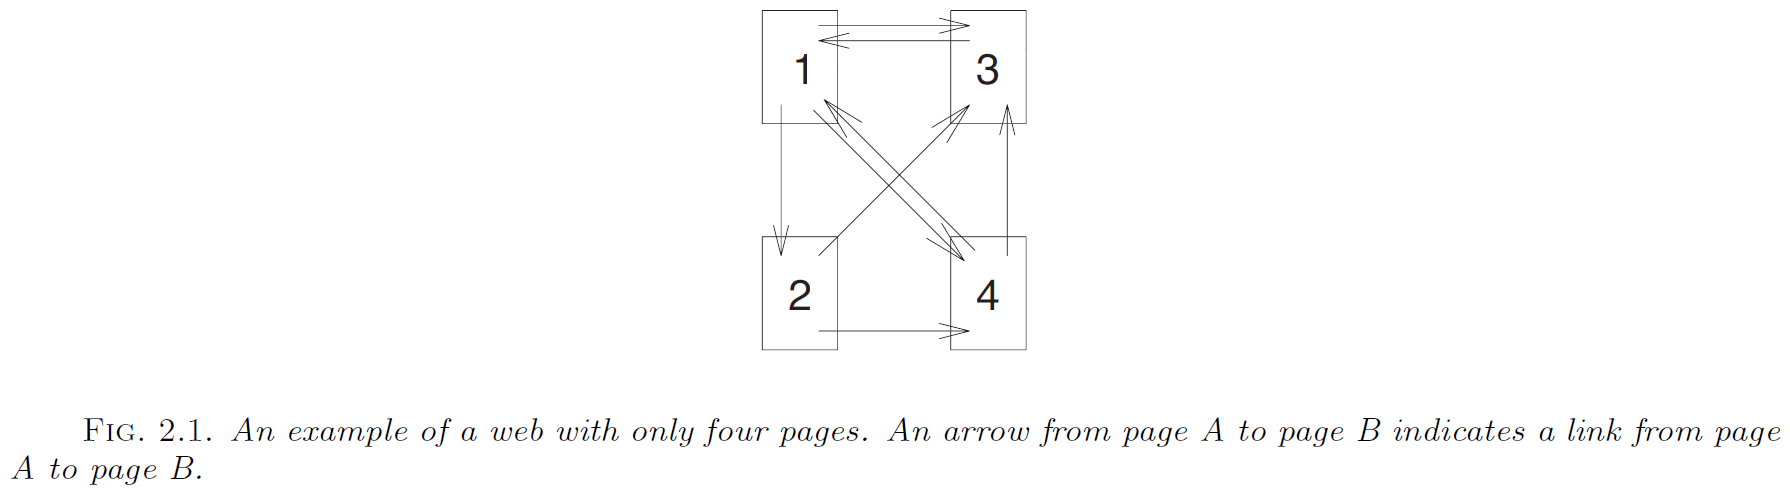

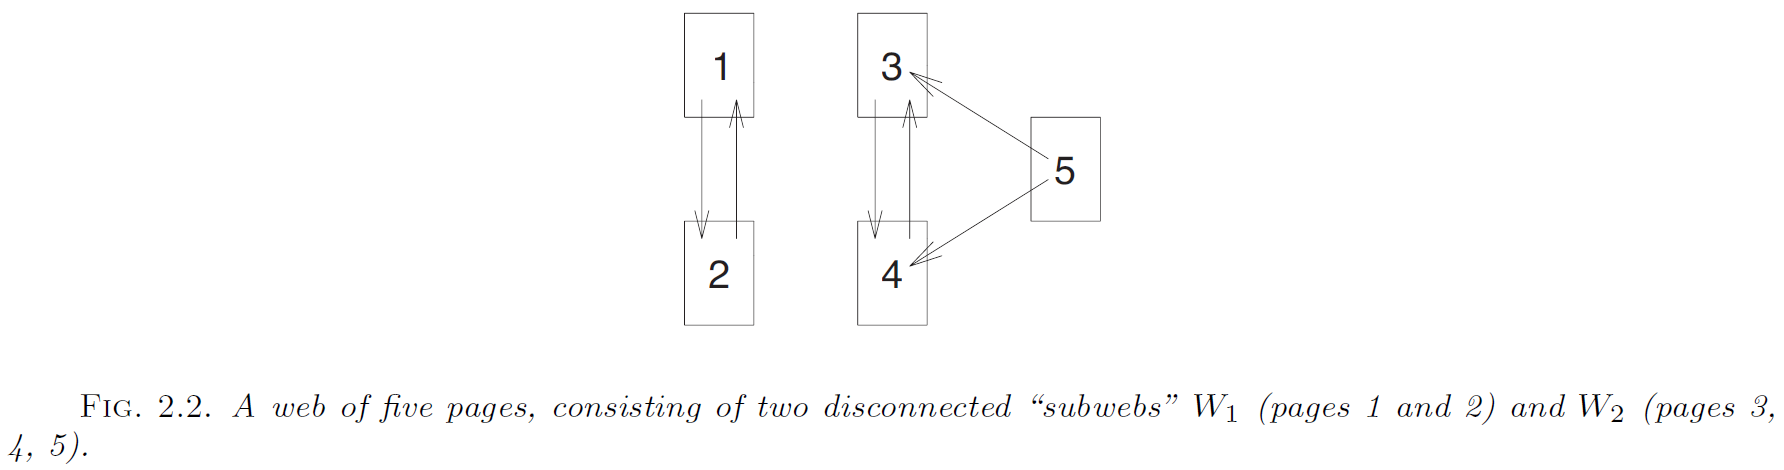

In [ ]:
def show_results(v, e):
  g = GraphFrame(v, e)
  g.edges.show()
  results = g.pageRank(resetProbability=0.15, maxIter=10)

  #normalize results
  id = [int(x) for x in results.vertices.select("id").rdd.map(lambda x: x[0]).collect()]
  pr = results.vertices.select("pagerank").rdd.map(lambda x: x[0]).collect()
  pr_sum = sum(pr)
  pr_norm = [x/pr_sum for x in pr]

  print("Raw Results")
  results.vertices.select("id", "pagerank").show()

  print("Normalized Results")
  print("id | pagerank")
  for i in range(len(id)):
    print(f" {id[i]} | {pr_norm[i]}")
  print()

#Fig 2.1 Example
v = sqlContext.createDataFrame([("1", ),("2", ),("3", ),("4", )],["id", ])
e = sqlContext.createDataFrame([
  ("1", "2", "link"),
  ("1", "3", "link"),
  ("1", "4", "link"),
  ("2", "3", "link"),
  ("2", "4", "link"),
  ("3", "1", "link"),
  ("4", "1", "link"),
  ("4", "3", "link"),
], ["src", "dst", "relationship"])

print("Fig 2.1 Example")
show_results(v, e)

#Fig 2.2 Example
v = sqlContext.createDataFrame([("1", ),("2", ),("3", ),("4", ),("5", )],["id", ])
e = sqlContext.createDataFrame([
  ("1", "2", "link"),
  ("2", "1", "link"),
  ("3", "4", "link"),
  ("4", "3", "link"),
  ("5", "3", "link"),
  ("5", "4", "link"),
], ["src", "dst", "relationship"])

print("Fig 2.2 Example")
show_results(v, e)

Fig 2.1 Example
+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  1|  2|        link|
|  1|  3|        link|
|  1|  4|        link|
|  2|  3|        link|
|  2|  4|        link|
|  3|  1|        link|
|  4|  1|        link|
|  4|  3|        link|
+---+---+------------+

Raw Results
+---+------------------+
| id|          pagerank|
+---+------------------+
|  1|1.4729483816191948|
|  3|1.1517951593440134|
|  2|0.5671094097639751|
|  4|0.8081470492728166|
+---+------------------+

Normalized Results
id | pagerank
 1 | 0.36823709540479876
 3 | 0.2879487898360034
 2 | 0.1417773524409938
 4 | 0.20203676231820417

Fig 2.2 Example
+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  1|  2|        link|
|  2|  1|        link|
|  3|  4|        link|
|  4|  3|        link|
|  5|  3|        link|
|  5|  4|        link|
+---+---+------------+

Raw Results
+---+-------------------+
| id|           pagerank|
+---+-------------------+
|  1| 1.0000000000000002|

Below are the normalized pagerank results of the examples as calculated in the lecture slides:

Fig 2.1 Example (slide 9)

|id|pagerank (slide)|pagerank (graphframes)|
|------|------|------|
|1|0.387|0.36823709540479876|
|2|0.129|0.1417773524409938|
|3|0.290|0.2879487898360034|
|4|0.194|0.20203676231820417|

Fig 2.2 Examples (slide 14)

|id|pagerank (slide)|pagerank (graphframes)|
|------|------|------|
|1|0.2|0.20000000000000004|
|2|0.2|0.20000000000000004|
|3|0.285|0.285|
|4|0.285|0.285|
|5|0.03|0.030000000000000006|

As is shown, the PageRank results from the built in GraphFrames pagerank function is very comparible to the results calculated in class for the two examples from the $25,000,000,000 paper. For the Fig 2.2 example, the results are identicle. For the Fig 2.1 example, the results are very similar, but there is a slight discrepency, especially with the results from pages 1 and 2.